<a href="https://colab.research.google.com/github/nischal0x01/farePrediction/blob/main/FarePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [141]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [142]:
# Loading the file
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/uber.csv'  # Update this path based on your actual file location in Google Drive
df = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [143]:
# Verify the loaded dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [144]:
#Handling Missing Data



# Check for missing values in the dataset
missing_data = df.isnull().sum()

In [145]:
# Display the percentage of missing values for each column
missing_percentage = (missing_data / len(df)) * 100
print("Missing Data Percentage:\n", missing_percentage)

Missing Data Percentage:
 Unnamed: 0           0.0000
key                  0.0000
fare_amount          0.0000
pickup_datetime      0.0000
pickup_longitude     0.0000
pickup_latitude      0.0000
dropoff_longitude    0.0005
dropoff_latitude     0.0005
passenger_count      0.0000
dtype: float64


In [146]:
# Drop rows with missing values
df_cleaned = df.dropna()


In [147]:
# Check if missing data has been removed
print(df_cleaned.isnull().sum())

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [148]:
# Loop through each numeric column and fill missing values with the median of that column
for col in df.select_dtypes(include=np.number):
    df[col].fillna(df[col].median(), inplace=True)

In [149]:
# Check again for missing data after imputation
print(df.isnull().sum())

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [150]:
# Feature Engineering


# Convert 'pickup_datetime' to datetime if not already in that format
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [151]:
# Extract hour from 'pickup_datetime'
df['pickup_hour'] = df['pickup_datetime'].dt.hour

In [152]:
# Define function to categorize time of day
def categorize_time(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

In [153]:
# Apply the function to create a new 'time_of_day' column
df['time_of_day'] = df['pickup_hour'].apply(categorize_time)


In [154]:
# Verify the new column
print(df[['pickup_hour', 'time_of_day']].head())

   pickup_hour time_of_day
0           19     evening
1           20     evening
2           21       night
3            8     morning
4           17     evening


In [155]:
from math import radians, sin, cos, sqrt, atan2


In [156]:
# Function to calculate Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [157]:
# Apply the Haversine function to calculate the distance for each ride
df['distance_km'] = df.apply(lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'],
                                                   row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

In [158]:
# Verify the new column
print(df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'distance_km']].head())

   pickup_latitude  pickup_longitude  dropoff_latitude  dropoff_longitude  \
0        40.738354        -73.999817         40.723217         -73.999512   
1        40.728225        -73.994355         40.750325         -73.994710   
2        40.740770        -74.005043         40.772647         -73.962565   
3        40.790844        -73.976124         40.803349         -73.965316   
4        40.744085        -73.925023         40.761247         -73.973082   

   distance_km  
0     1.683323  
1     2.457590  
2     5.036377  
3     1.661683  
4     4.475450  


In [159]:
# Categorize distance into 'short', 'medium', and 'long'
def categorize_distance(distance):
    if distance < 2:
        return 'short'
    elif 2 <= distance < 8:
        return 'medium'
    else:
        return 'long'

In [160]:
# Apply the function to create a new 'distance_category' column
df['distance_category'] = df['distance_km'].apply(categorize_distance)

In [161]:
# Verify the new column
print(df[['distance_km', 'distance_category']].head())

   distance_km distance_category
0     1.683323             short
1     2.457590            medium
2     5.036377            medium
3     1.661683             short
4     4.475450            medium


In [162]:
#Splitting the database


In [163]:
from sklearn.model_selection import train_test_split


In [164]:
# Features and target variable
X = df.drop(['fare_amount'], axis=1)  # Drop the target column 'fare_amount'
y = df['fare_amount']  # Target variable

In [165]:
# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [166]:
# Print the size of the training and testing sets
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 140000
Test set size: 60000


In [167]:
#Data Scaling and Normalization


In [168]:
from sklearn.preprocessing import StandardScaler

In [169]:
# Initialize the scaler
scaler = StandardScaler()

In [170]:
# Select only numeric columns for scaling
numeric_cols = X_train.select_dtypes(include=[np.number]).columns


In [171]:
# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])


In [172]:
# Transform the test data
X_test_scaled = scaler.transform(X_test[numeric_cols])

In [173]:
# Verify the result
print("Scaled Training Data:")
print(X_train_scaled[:5])  # Display first 5 rows of the scaled training set

Scaled Training Data:
[[ 0.78602268 -0.12547564  0.09815223 -0.10380115  0.12104494 -0.48237075
  -0.84199713 -0.04776201]
 [ 0.68269635 -0.12506577  0.0997789  -0.10515233  0.11810617 -0.48237075
   0.99910446 -0.04895894]
 [-1.08067116 -0.12477239  0.09704678 -0.10237727  0.12485944  0.22243012
  -1.76254792 -0.03731604]
 [ 0.93918744 -0.12548152  0.09889064 -0.10422332  0.11778434 -0.48237075
  -0.68857199 -0.0497222 ]
 [-0.98497355 -0.12470381  0.0956604  -0.10571471  0.11530797 -0.48237075
  -0.84199713 -0.05006353]]


In [174]:
from sklearn.preprocessing import MinMaxScaler

In [175]:
# Initialize the MinMaxScaler
min_max_scaler = MinMaxScaler()

In [176]:
# Select only numeric columns for scaling
numeric_cols = X_train.select_dtypes(include=[np.number]).columns


In [177]:
# Fit and transform only the numeric columns for the training set
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])


In [178]:
# Apply the same scaler to the test set numeric columns
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

In [179]:
# Convert scaled data back to DataFrame (with the same column names)
X_train_scaled_numeric = pd.DataFrame(X_train_scaled_numeric, columns=numeric_cols, index=X_train.index)
X_test_scaled_numeric = pd.DataFrame(X_test_scaled_numeric, columns=numeric_cols, index=X_test.index)

In [180]:
# Now combine scaled numeric columns with non-numeric columns (if any)
X_train_scaled = X_train_scaled_numeric.join(X_train.drop(columns=numeric_cols))
X_test_scaled = X_test_scaled_numeric.join(X_test.drop(columns=numeric_cols))

In [181]:
# Verify the result
print("Scaled Training Data (first 5 rows):")
print(X_train_scaled.head())

Scaled Training Data (first 5 rows):
        Unnamed: 0  pickup_longitude  pickup_latitude  dropoff_longitude  \
21269     0.786023         -0.125476         0.098152          -0.103801   
187660    0.682696         -0.125066         0.099779          -0.105152   
774      -1.080671         -0.124772         0.097047          -0.102377   
184577    0.939187         -0.125482         0.098891          -0.104223   
37127    -0.984974         -0.124704         0.095660          -0.105715   

        dropoff_latitude  passenger_count  pickup_hour  distance_km  \
21269           0.121045        -0.482371    -0.841997    -0.047762   
187660          0.118106        -0.482371     0.999104    -0.048959   
774             0.124859         0.222430    -1.762548    -0.037316   
184577          0.117784        -0.482371    -0.688572    -0.049722   
37127           0.115308        -0.482371    -0.841997    -0.050064   

                                  key           pickup_datetime time_of_day  \


In [182]:
# Correlation Analysis


In [183]:
# Select only numeric columns from the dataset
numeric_df = df.select_dtypes(include=[np.number])

In [184]:
# Compute the correlation matrix for numeric features
correlation_matrix = numeric_df.corr()

In [185]:
# Display the correlation of features with the target variable 'fare_amount'
print(correlation_matrix['fare_amount'].sort_values(ascending=False))

fare_amount          1.000000
distance_km          0.024684
pickup_longitude     0.010457
passenger_count      0.010150
dropoff_longitude    0.008985
Unnamed: 0           0.000589
pickup_latitude     -0.008481
dropoff_latitude    -0.011013
pickup_hour         -0.021473
Name: fare_amount, dtype: float64


In [186]:
#Visualize

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt

In [188]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Axes: >

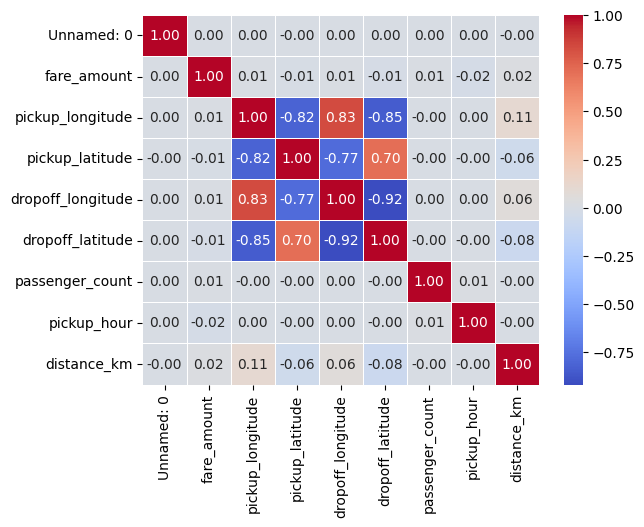

In [189]:
# Draw the heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

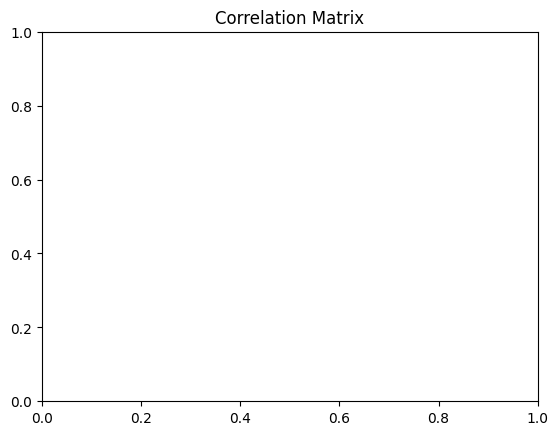

In [190]:
# Show the plot
plt.title('Correlation Matrix')
plt.show()

In [191]:
# Splitting the Dataset


In [192]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [193]:
# Select only the numerical columns for regression
numerical_df = df.select_dtypes(include=[np.number])

In [194]:
# Define features (X) and target (y)
X = numerical_df.drop(['fare_amount'], axis=1)  # Keep only the features
y = df['fare_amount']  # Target variable


In [195]:
# Split into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)


In [196]:
# Initialize Linear Regression model
linear_model = LinearRegression()

In [197]:
# Train the model
linear_model.fit(X_train, y_train)

LinearRegression()

In [198]:
# Predict the fare amount on the test set
y_pred = linear_model.predict(X_test)

In [199]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


In [200]:
# Print the evaluation metrics
print(f"Linear Regression - Mean Squared Error (MSE): {mse}")
print(f"Linear Regression - Mean Absolute Error (MAE): {mae}")
print(f"Linear Regression - R-squared (R²): {r2}")


Linear Regression - Mean Squared Error (MSE): 103.58974465910256
Linear Regression - Mean Absolute Error (MAE): 6.058658904353604
Linear Regression - R-squared (R²): 0.0009960688662122852


In [201]:
# Fine Tuning


In [202]:
from sklearn.model_selection import GridSearchCV

In [203]:
# Define the model (e.g., GradientBoostingRegressor)
from sklearn.ensemble import GradientBoostingRegressor


In [204]:
gb_model = GradientBoostingRegressor()

In [205]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 1.0]
}

In [ ]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)